In [3]:
# Cell 1: Import libraries and set random seeds for reproducibility
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries imported and seeds set!")


✅ Libraries imported and seeds set!


In [4]:
# Cell 2: Load dataset metadata and split data into training and validation sets
# Adjust 'dataset_path' as needed for your environment.
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Read CSV files
labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

# Merge metadata on 'patientId' and map targets: 0 = Normal, 1 = Pneumonia
merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

# Split data into 80% training and 20% validation with stratification
train_df, val_df = train_test_split(labels_simple, test_size=0.2, random_state=SEED, stratify=labels_simple['Target'])
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 21347
Validation samples: 5337


In [5]:
# Cell 3: Define a function to load and preprocess DICOM images
# This function reads a DICOM file, normalizes pixel values, resizes to (240,240),
# and converts the image from grayscale to 3-channel RGB.
def load_preprocess_dicom(dicom_path, img_size=(240, 240)):
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize pixel values to [0, 1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize image to desired dimensions
    img_resized = cv2.resize(img_norm, img_size)
    # Convert grayscale image to RGB by stacking the single channel three times
    img_rgb = np.stack([img_resized]*3, axis=-1)
    return img_rgb

# Test the function on a sample image
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", train_df.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image shape (should be 240x240x3):", sample_img.shape)


✅ Sample image shape (should be 240x240x3): (240, 240, 3)


In [6]:
# Cell 4: Create data generators for training and validation
# We create an infinite data generator for training (to avoid running out of data) 
# and a finite generator for validation.
def data_generator(df, batch_size=64, img_size=(240, 240), infinite=True):
    def gen():
        if infinite:
            while True:
                # Shuffle the DataFrame at the start of each epoch
                shuffled_df = df.sample(frac=1).reset_index(drop=True)
                for _, row in shuffled_df.iterrows():
                    patient_id = row['patientId']
                    label = 1 if row['Target'] == 'Pneumonia' else 0
                    dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                    img = load_preprocess_dicom(dicom_path, img_size)
                    yield img, label
        else:
            for _, row in df.iterrows():
                patient_id = row['patientId']
                label = 1 if row['Target'] == 'Pneumonia' else 0
                dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                img = load_preprocess_dicom(dicom_path, img_size)
                yield img, label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 3), ())
    )
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 64
train_ds = data_generator(train_df, batch_size=BATCH_SIZE, img_size=(240,240), infinite=True)
val_ds = data_generator(val_df, batch_size=BATCH_SIZE, img_size=(240,240), infinite=False)
print("✅ Data generators created with batch size:", BATCH_SIZE)


✅ Data generators created with batch size: 64


In [7]:
# Cell 5: Build the EfficientNetB1 model with a frozen base
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# Load EfficientNetB1 with ImageNet weights, without the top classification layer
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(240,240,3))

# Freeze the base model layers (initial stage)
base_model.trainable = False

# Build the complete model by adding a global average pooling layer and a custom classifier head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with an initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)          │ (None, 8, 8, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,739,336 (25.71 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 6,575,239 (25.08 MB)

In [8]:
# Cell 6: Compute class weights to address class imbalance
y_train = train_df['Target'].apply(lambda x: 1 if x == 'Pneumonia' else 0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}
print("✅ Class weights computed:", class_weights)


✅ Class weights computed: {0: 0.6454314567333858, 1: 2.219022869022869}


In [9]:
# Cell 7: Define callbacks (EarlyStopping and ReduceLROnPlateau)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("✅ Callbacks defined.")


✅ Callbacks defined.


In [10]:
# Cell 8: Train the EfficientNetB1 model with the frozen base (initial training of the classifier head)
steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch)

EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,  # One epoch = one full pass over training data
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Steps per epoch: 334
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5531 - loss: 0.6906

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


334/334 ━━━━━━━━━━━━━━━━━━━━ 598s 2s/step - accuracy: 0.5529 - loss: 0.6906 - val_accuracy: 0.2252 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.2474 - loss: 0.6961 - val_accuracy: 0.7748 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.3334 - loss: 0.6972 - val_accuracy: 0.2252 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.3605 - loss: 0.6919 - val_accuracy: 0.7748 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.6600 - loss: 0.6930
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
334/334 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.6595 - loss: 0.6930 - val_accuracy: 0.7748 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 331s 993ms/step - accuracy: 0.7700 - loss: 0.6921 - v

In [11]:
# Cell 9: Clone the current model as the frozen-base model for later evaluation
model_frozen = tf.keras.models.clone_model(model)
model_frozen.build((None, 240, 240, 3))  # Ensure the model is built with the correct input shape
model_frozen.set_weights(model.get_weights())
print("✅ Frozen-base model cloned.")


✅ Frozen-base model cloned.


In [12]:
# Cell 10: Unfreeze the EfficientNetB1 base layers for fine-tuning (Stage 2)
# Here, we unfreeze all layers. Optionally, you can unfreeze only the top layers.
base_model.trainable = True

# Optionally, to partially unfreeze:
# fine_tune_at = 100  # unfreeze last 100 layers
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
# for layer in base_model.layers[fine_tune_at:]:
#     layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("✅ Base model layers unfrozen for fine-tuning.")


✅ Base model layers unfrozen for fine-tuning.


In [13]:
# Cell 11: Fine-tune the model with the unfrozen base layers
FINE_TUNE_EPOCHS = 10  # Adjust based on your observations

fine_tune_history = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 709s 2s/step - accuracy: 0.5760 - loss: 0.7463 - val_accuracy: 0.3581 - val_loss: 0.7124 - learning_rate: 1.0000e-05
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.6867 - loss: 0.5897 - val_accuracy: 0.5132 - val_loss: 0.6847 - learning_rate: 1.0000e-05
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.7146 - loss: 0.5383 - val_accuracy: 0.7306 - val_loss: 0.5020 - learning_rate: 1.0000e-05
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.7308 - loss: 0.5037 - val_accuracy: 0.7570 - val_loss: 0.4761 - learning_rate: 1.0000e-05
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.7532 - loss: 0.4788 - val_accuracy: 0.7607 - val_loss: 0.4702 - learning_rate: 1.0000e-05
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step - accuracy: 0.7608 - loss: 0.4660 - val_accuracy: 0.7604 - val_loss: 0.4715 - learning_rate: 1.0000e-05
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - acc

2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 344ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


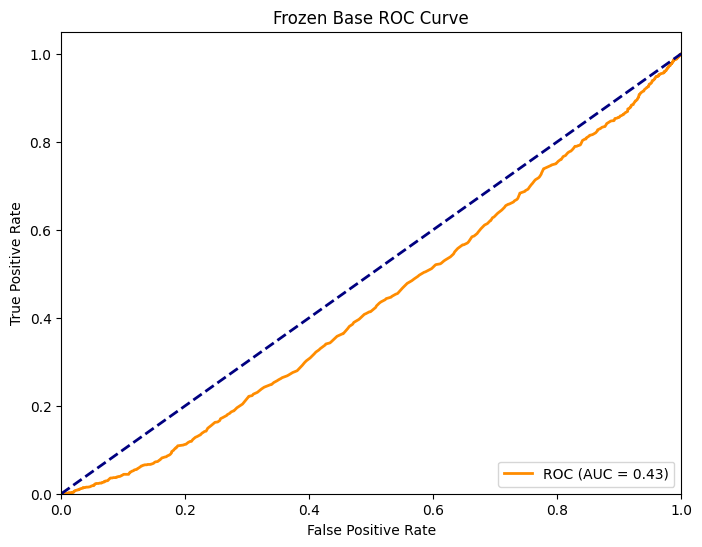

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

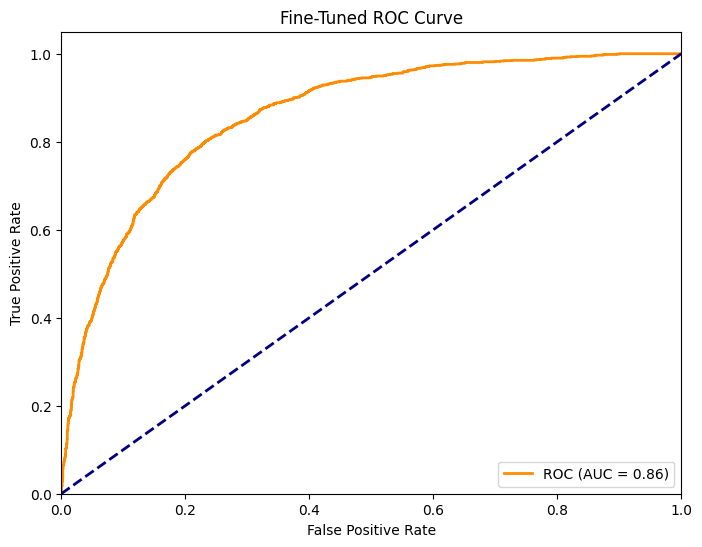

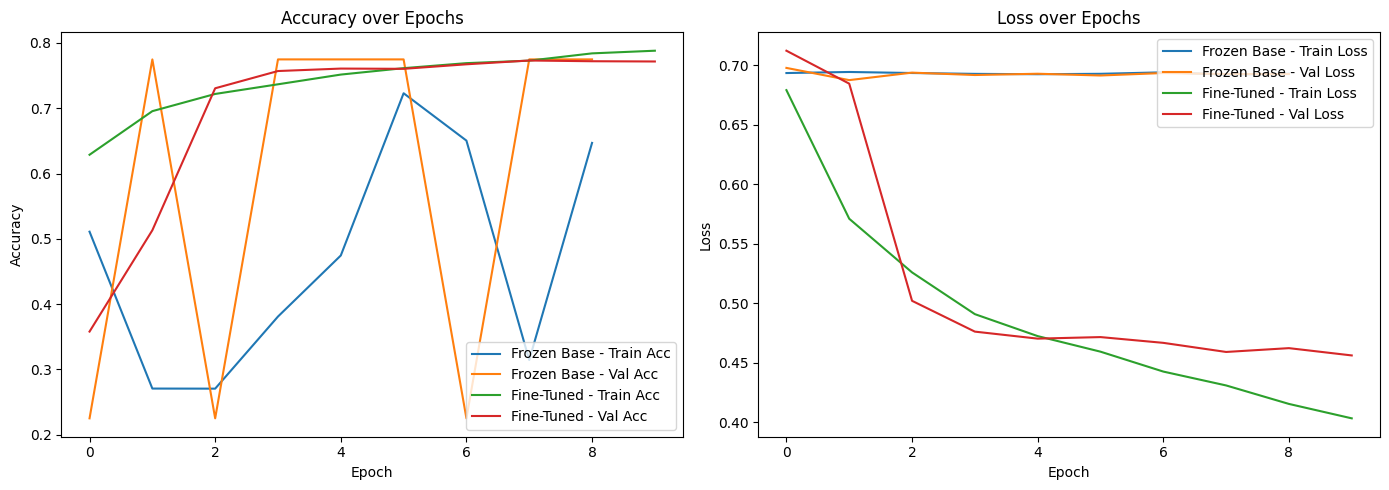

In [14]:
# Cell 12: Evaluate the models and plot learning curves
# Define a function to evaluate a model on the validation dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def evaluate_model(model, dataset, stage_name=""):
    y_true = []
    y_pred = []
    y_scores = []
    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())
        y_scores.extend(preds.flatten())
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    print(f"=== {stage_name} Model ===")
    print("Accuracy: {:.2f}%".format(acc * 100))
    print("Precision: {:.2f}".format(prec))
    print("Recall: {:.2f}".format(rec))
    print("F1-Score: {:.2f}".format(f1))
    print("Confusion Matrix:\n", cm)
    print("AUC: {:.2f}".format(roc_auc))
    print()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{stage_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the frozen-base model
evaluate_model(model_frozen, val_ds, stage_name="Frozen Base")

# Evaluate the fine-tuned model (current 'model')
evaluate_model(model, val_ds, stage_name="Fine-Tuned")

# Plot combined learning curves (accuracy and loss)
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Frozen Base - Train Acc')
plt.plot(history.history['val_accuracy'], label='Frozen Base - Val Acc')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-Tuned - Train Acc')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-Tuned - Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Frozen Base - Train Loss')
plt.plot(history.history['val_loss'], label='Frozen Base - Val Loss')
plt.plot(fine_tune_history.history['loss'], label='Fine-Tuned - Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-Tuned - Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
